In [1218]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import seaborn as sns
import statsmodels.api as sm
import random
from sklearn.feature_selection import SequentialFeatureSelector #Para stepwise
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV, Ridge #Para Ridge
from sklearn.linear_model import LassoCV,Lasso

plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')
random.seed(123)

## Extracción de datos

In [1219]:
songs_df = pd.read_csv('songs.csv')

songs_df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## Separar las variables Categóricas y Numéricas

### Extracción de variables numéricas

In [1220]:
numerical_cols = [cname for cname in songs_df.columns if songs_df[cname].dtype in ['int64', 'float64']]
numerical_cols.remove('mode')
print("Variables numericas: ",numerical_cols)
print("Cantidad: ", len(numerical_cols))

Variables numericas:  ['duration_ms', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Cantidad:  13


### Extracción de variables categóricas

In [1221]:
categorical_cols = [cname for cname in songs_df.columns if songs_df[cname].dtype in ["object", "bool"]]
categorical_cols.append('mode')
print("Variables categoricas: ",categorical_cols)
print("Cantidad: ", len(categorical_cols))

Variables categoricas:  ['artist', 'song', 'explicit', 'genre', 'mode']
Cantidad:  5


### Mapa de correlación de las variables

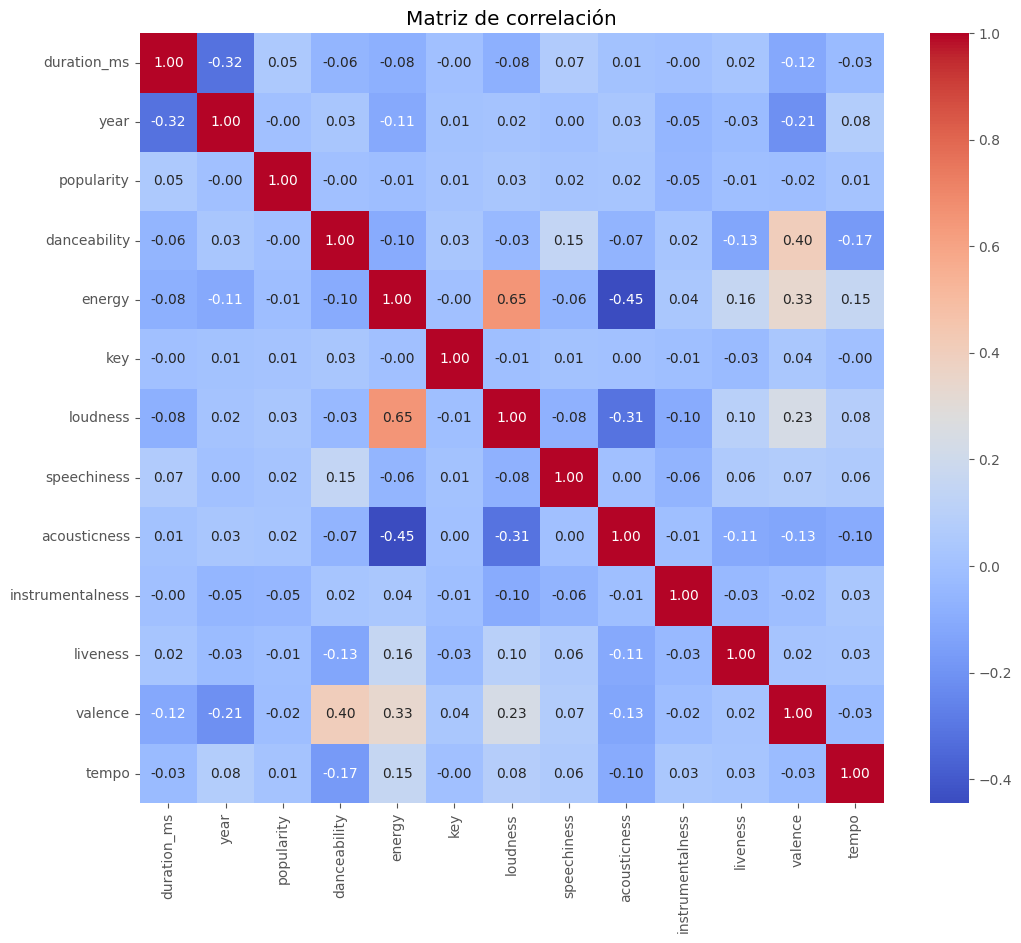

In [1222]:
correlation_matrix = songs_df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title("Matriz de correlación")
plt.show()

En el mapa podemos observar como es no existe correlación en casi todas las variables, exceptuando en entre las variables de 'danceability' y 'loudness', estás presentan una leve correlación entre ellas.

## Análisis de variables numéricas

### Análisis de valores atípicos

<Axes: >

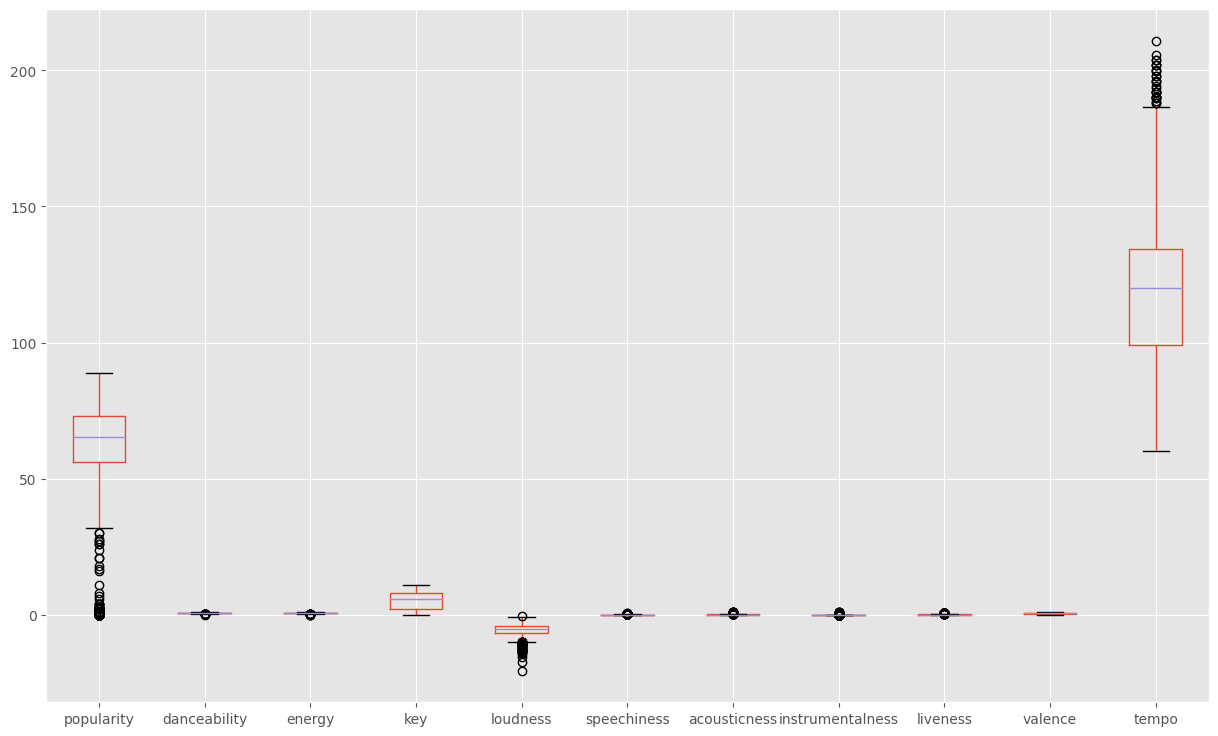

In [1223]:
songs_df[['popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].boxplot()

Podemos notar que en lo general no existen valores atípicos en las variables de nuestro set de datos

<Axes: >

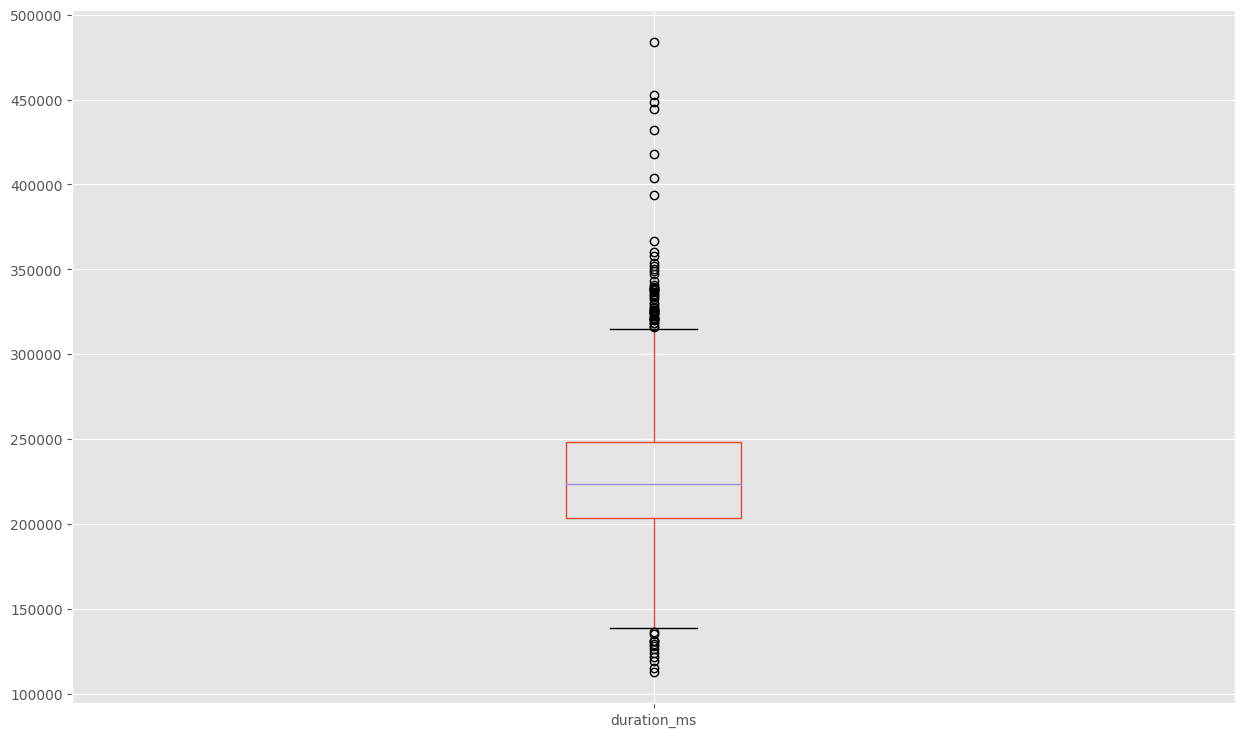

In [1224]:
songs_df[['duration_ms']].boxplot()

Sin embargo, cuando revisamos la variable de 'duration_ms' podemos observer que si existen algunos valores demasiado grandes, los cuales podrían afectar las predicciones de nuestros modelos.

Eliminamos valores atípicos

In [1225]:
songs_df = songs_df[songs_df["duration_ms"] < 375000]

Verificación de que removimos los valores atípicos

<Axes: >

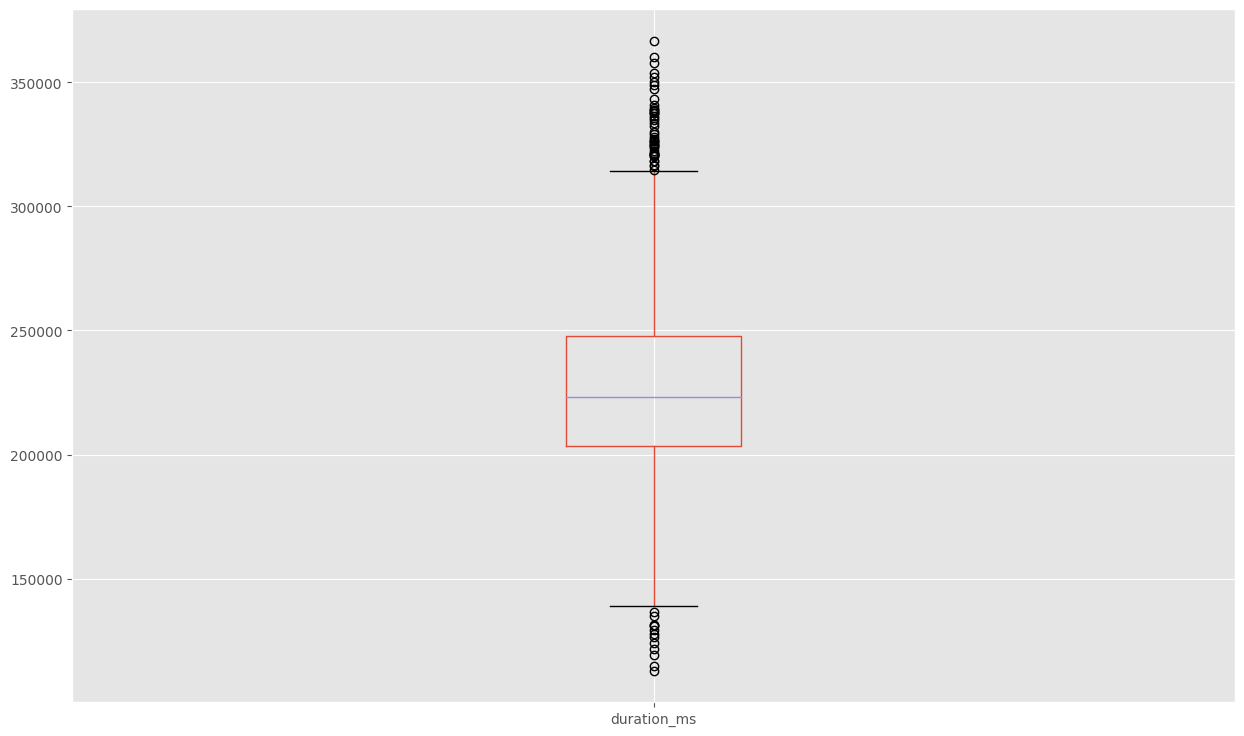

In [1226]:
songs_df[['duration_ms']].boxplot()

## Análisis de variables categóricas

In [1227]:
counts = songs_df['explicit'].value_counts()

print(counts)

False    1444
True      548
Name: explicit, dtype: int64


In [1228]:
counts = songs_df['genre'].value_counts()

print(counts)

pop                                      425
hip hop, pop                             277
hip hop, pop, R&B                        244
pop, Dance/Electronic                    221
pop, R&B                                 178
hip hop                                  123
hip hop, pop, Dance/Electronic            78
rock                                      58
rock, pop                                 43
Dance/Electronic                          38
rock, metal                               38
pop, latin                                28
pop, rock                                 26
set()                                     22
hip hop, Dance/Electronic                 16
latin                                     14
pop, rock, metal                          14
hip hop, pop, latin                       14
R&B                                       13
pop, rock, Dance/Electronic               13
country                                   10
metal                                      9
hip hop, p

Convertimos las variables categóricas a numéricas utilizando la función de get_dummies de pandas para transformar cada una de las categorías de nuestras variables categóricas en una variable nueva y colocarles un valor de 0 o 1 en caso la canción sea parte de la misma.

También quitamos la característica de danceability, ya que muestra un poco de correlación con loudness y valence, y también a los artistas, ya que son demasiadas categorías que no poseen mucho impacto al momento de realizar las predicciones.

In [1229]:
categorical_cols.remove('mode')
categorical_cols.remove('song')
categorical_cols.remove('artist')
numerical_cols.remove('popularity')
numerical_cols.remove('danceability')
songs_df.pop('song')
songs_df.pop('artist')
songs_df.pop('danceability')
songs_df = pd.get_dummies(songs_df, columns=['explicit', 'genre'])

## Obtención de datos de entrenamiento y de prueba

In [1230]:
target = songs_df.pop("popularity")
data = songs_df


In [1231]:
random.seed(123)
data_train, data_test, target_train, target_test = train_test_split(data, target,test_size=0.3,train_size=0.7)

### Métricas AIC y BIC

In [1232]:
# calculate aic for regression 
def calculate_aic(n, mse, num_params):
 aic = n * np.log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * np.log(mse) + num_params * np.log(n)
 return bic

## Modelos

### Modelo 1

Realizaremos el modelo lineal usando múltiples predictores

In [1233]:
modelo1 = LinearRegression()
modelo1.fit(data_train, target_train)
y_pred_modelo1 = modelo1.predict(data_test)

In [1234]:
sm.OLS(target_train,data_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.619
Date:                Wed, 08 May 2024   Prob (F-statistic):            0.00134
Time:                        12:27:22   Log-Likelihood:                -6210.7
No. Observations:                1394   AIC:                         1.256e+04
Df Residuals:                    1325   BIC:                         1.292e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
duration_ms                                  3.574e-05   1.79e-05      1.999      0.046     6.7e-07    7.08e-05
year                                            0.0030      0.120      0.025      0.980      -0.232       0.238
energy                                         -5.1729      6.031     -0.858      0.391     -17.004       6.658
key                                             0.0909      0.165      0.552      0.581      -0.232       0.414
loudness                                        0.5225      0.425      1.228      0.220      -0.312       1.357
mode                                           -1.3615      1.206     -1.129      0.259      -3.727       1.004
speechiness                                    -5.7901      7.233     -0.801      0.424     -19.979       8.399
acousticness                                    3.5901      3.964      0.906      0.365      -4.187      11.367
instrumentalness                              -10.6213      6.935     -1.532      0.126     -24.226       2.983
liveness                                       -4.9201      4.409     -1.116      0.265     -13.569       3.729
valence                                         3.6881      3.063      1.204      0.229      -2.320       9.696
tempo                                           0.0109      0.023      0.479      0.632      -0.034       0.055
explicit_False                                 48.9478    234.884      0.208      0.835    -411.837     509.733
explicit_True                                  47.7014    234.988      0.203      0.839    -413.288     508.691
genre_Dance/Electronic                         -6.8566      9.718     -0.706      0.481     -25.921      12.208
genre_Folk/Acoustic, pop                       18.8472     22.995      0.820      0.413     -26.263      63.958
genre_Folk/Acoustic, rock                     -56.6438     22.626     -2.503      0.012    -101.030     -12.257
genre_Folk/Acoustic, rock, pop                 10.5543     22.747      0.464      0.643     -34.070      55.179
genre_R&B                                       6.7055     10.844      0.618      0.536     -14.567      27.978
genre_World/Traditional, Folk/Acoustic         18.9221     22.965      0.824      0.410     -26.131      63.975
genre_World/Traditional, hip hop                7.1798     23.392      0.307      0.759     -38.710      53.069
genre_World/Traditional, pop                    6.9355     22.688      0.306      0.760     -37.573      51.444
genre_World/Traditional, pop, Folk/Acoustic    10.3813     17.058      0.609      0.543     -23.082      43.844
genre_World/Traditional, rock                   3.5462     17.036      0.208      0.835     -29.875      36.967
genre_World/Traditional, rock, pop            -60.1598     

In [1235]:
# Regression metrics
explained_variance_modelo1=metrics.explained_variance_score(target_test, y_pred_modelo1)
mean_absolute_error_modelo1=metrics.mean_absolute_error(target_test, y_pred_modelo1) 
mse_modelo1=metrics.mean_squared_error(target_test, y_pred_modelo1) 
median_absolute_error_modelo1=metrics.median_absolute_error(target_test, y_pred_modelo1)
r2_modelo1=metrics.r2_score(target_test, y_pred_modelo1)
k = modelo1.coef_.size
n = data_train.shape[0]
aic_modelo1 = calculate_aic(n,mse_modelo1,k)
bic_modelo1 = calculate_bic(n,mse_modelo1,k)

print('explained_variance: ', round(explained_variance_modelo1,4))   
print('r2: ', round(r2_modelo1,4))
print('MAE: ', round(mean_absolute_error_modelo1,4))
print('MSE: ', round(mse_modelo1,4))
print('RMSE: ', round(np.sqrt(mse_modelo1),4))
print('AIC: ',round(aic_modelo1,4))
print('BIC: ',round(bic_modelo1,4))

explained_variance:  -0.0195
r2:  -0.0237
MAE:  14.6095
MSE:  433.1809
RMSE:  20.813
AIC:  8609.1907
BIC:  8991.7058


#### Análisis de residuos

Text(0, 0.5, 'Residuales')

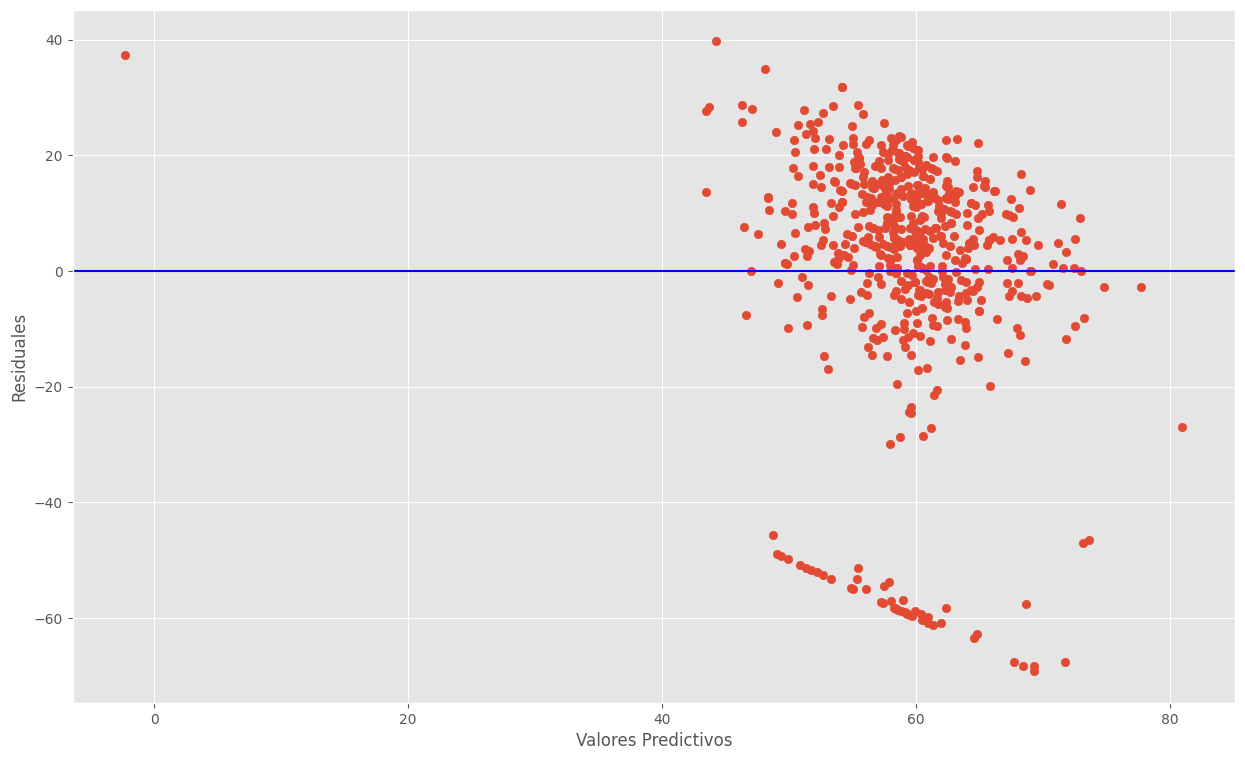

In [1236]:
resid_modelo1=target_test-y_pred_modelo1
plt.scatter(y_pred_modelo1,resid_modelo1)
plt.axhline(0,color='blue')
plt.xlabel('Valores Predictivos')
plt.ylabel('Residuales')

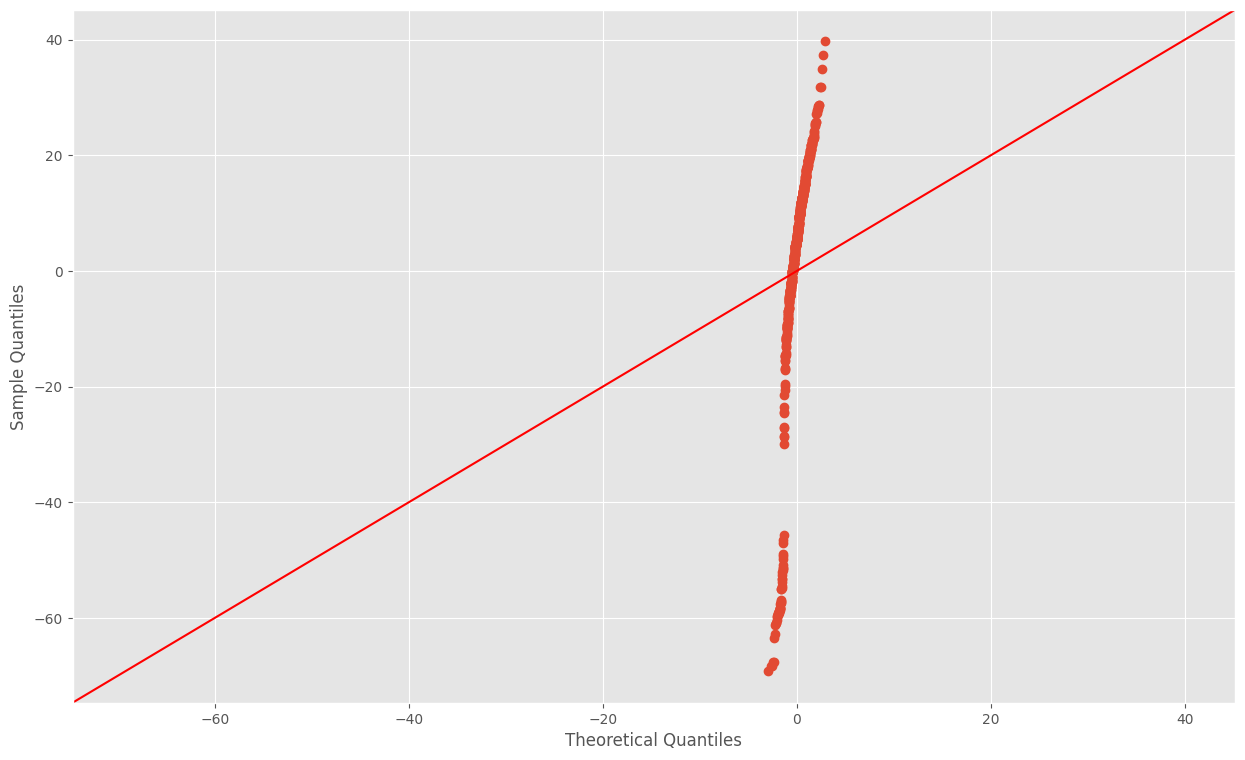

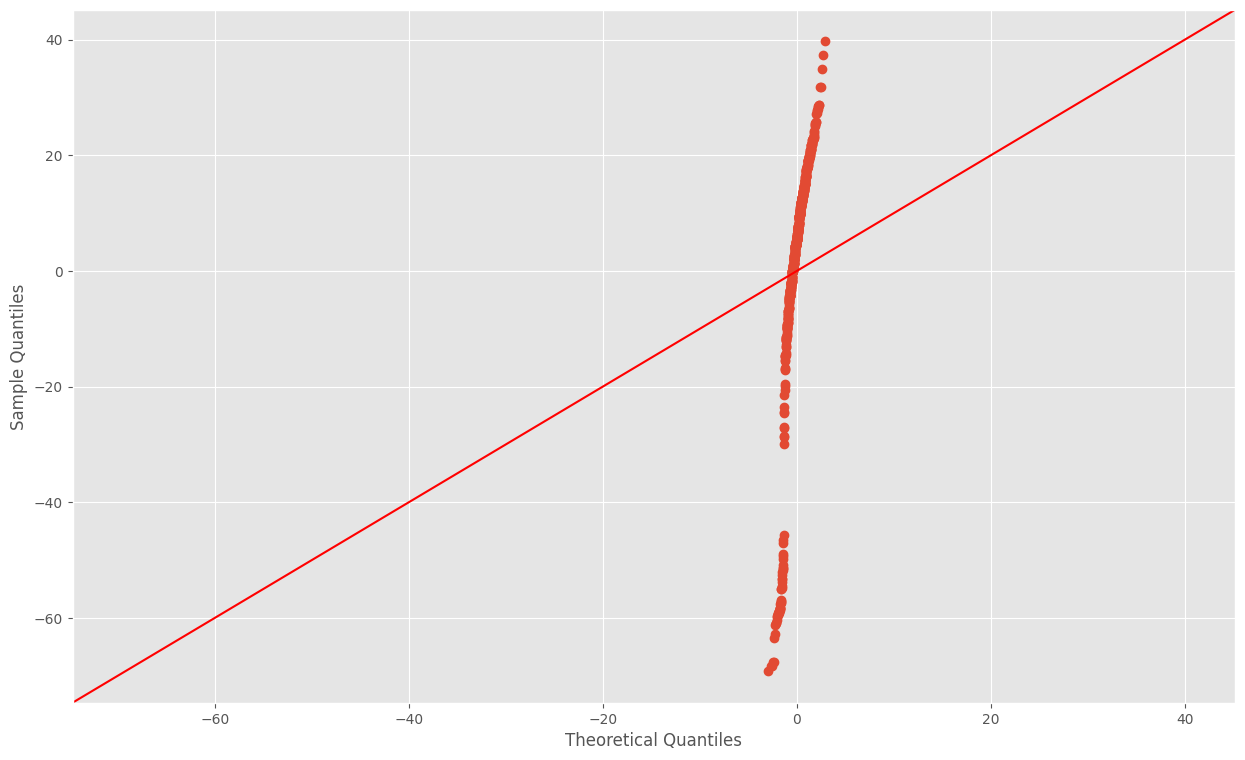

In [1237]:
sm.qqplot(resid_modelo1,line='45')

In [1238]:
k,p=sm.stats.diagnostic.lilliefors(resid_modelo1)
print("p =",p)

p = 0.0009999999999998899


In [1239]:
x_pred_modelo1 = modelo1.predict(data_train)
mse_modelo1_train=metrics.mean_squared_error(target_train, x_pred_modelo1) 

print("MES_train: ",round(mse_modelo1_train,4))
print('MSE_test: ', round(mse_modelo1,4))

MES_train:  433.8423
MSE_test:  433.1809


                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.619
Date:                Wed, 08 May 2024   Prob (F-statistic):            0.00134
Time:                        12:27:22   Log-Likelihood:                -6210.7
No. Observations:                1394   AIC:                         1.256e+04
Df Residuals:                    1325   BIC:                         1.292e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

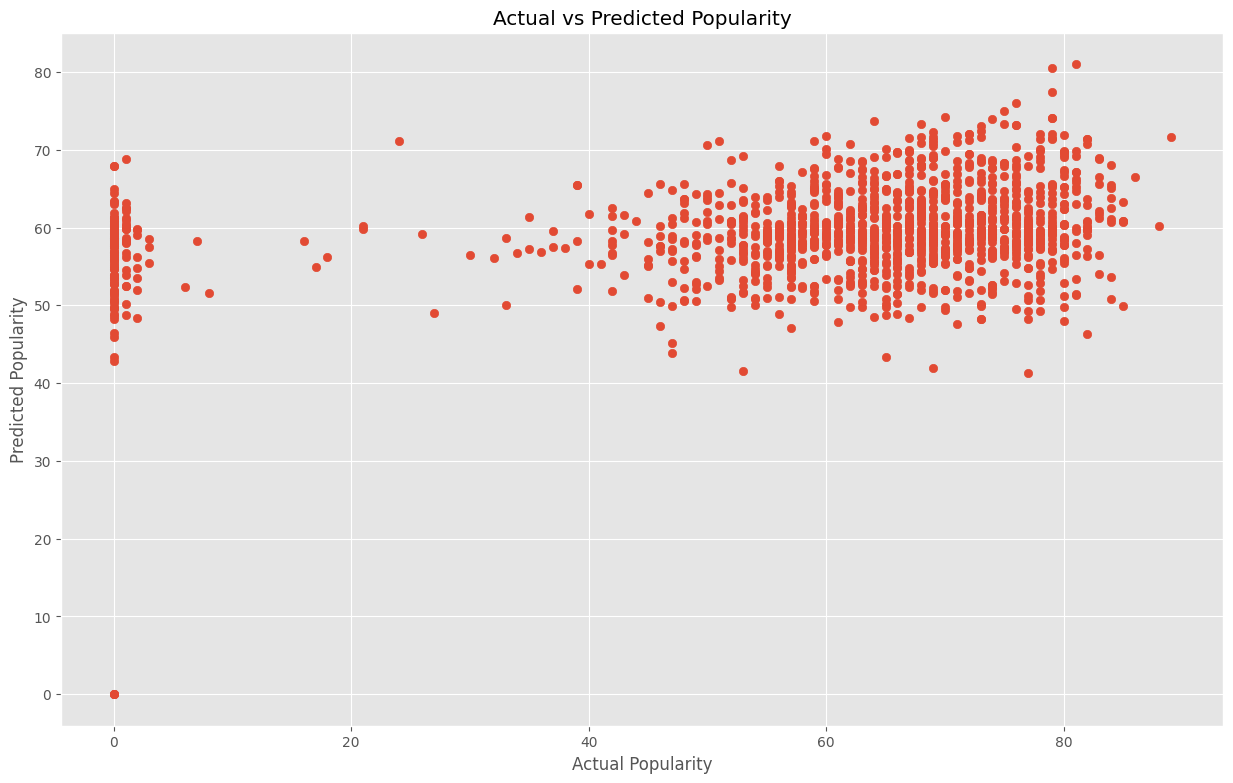

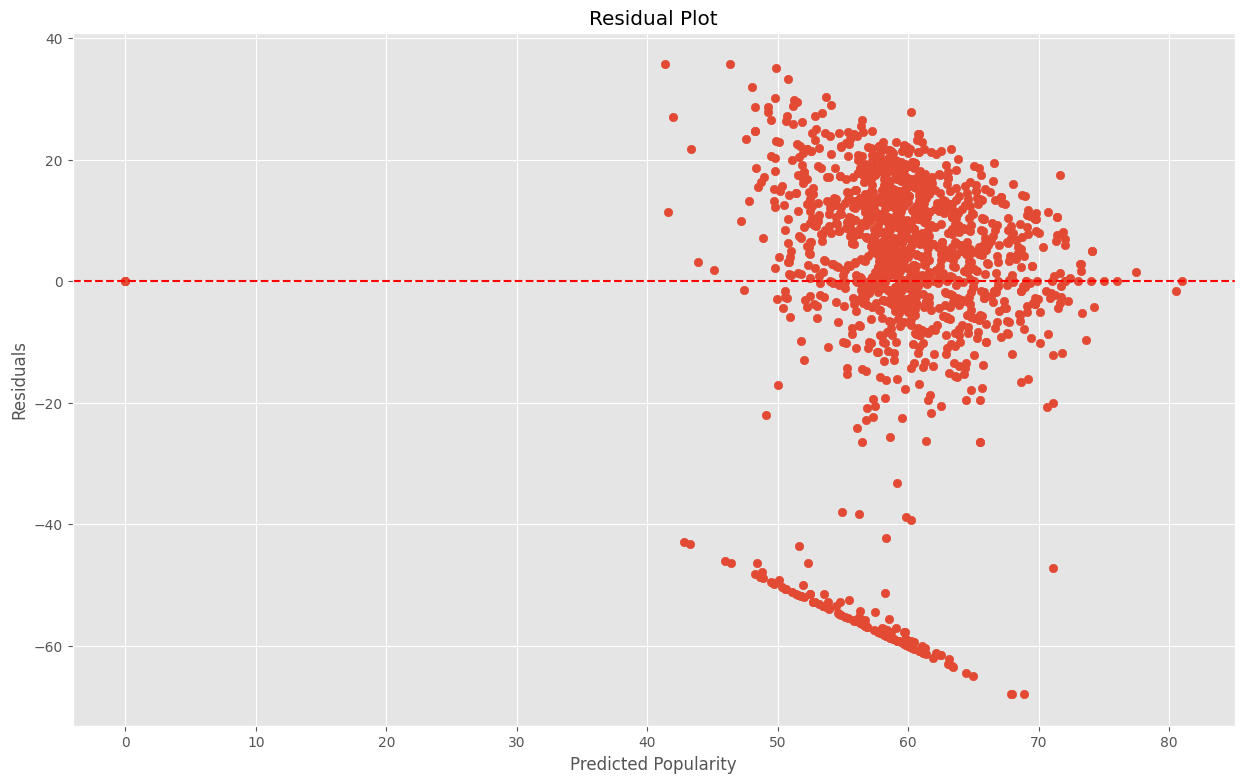

In [1240]:
# Añadir una constante para el término de intercepción
X_train_const = sm.add_constant(data_train)

# Modelo de regresión lineal
model = sm.OLS(target_train, X_train_const).fit()

# Resumen del modelo
print(model.summary())

# Hacer predicciones
predictions = model.predict(X_train_const)

# Gráfico de dispersión y línea de regresión
plt.scatter(target_train, predictions)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity')
plt.show()

# Gráfico de residuos
residuals = target_train - predictions
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Modelo 2

In [1241]:
lr = LinearRegression()

# Crea un modelo de seleccion de predicrores stepwise backward, con un k-fold de 5 en la validación cruzada
seleccionPredictores = SequentialFeatureSelector(lr, direction='backward', cv=5)
seleccionPredictores.fit(data_train[numerical_cols], target_train)

# Extrae los índices de los predictores
indicePredictores= seleccionPredictores.get_support(indices=True)

# Variables seleccionadas
columnas = data_train[numerical_cols].columns

In [1242]:
X_train_stw= data_train[numerical_cols].iloc[:,indicePredictores]
X_test_stw = data_test[numerical_cols].iloc[:,indicePredictores]

In [1243]:
# Train a linear regression model on the training set with the selected features
modelo2 = LinearRegression()
modelo2.fit(X_train_stw, target_train)

# Predict the target values on the testing set
y_pred_modelo2 = modelo2.predict(X_test_stw)

In [1244]:
# Regression metrics
explained_variance_modelo2=metrics.explained_variance_score(target_test, y_pred_modelo2)
mean_absolute_error_modelo2=metrics.mean_absolute_error(target_test, y_pred_modelo2) 
mse_modelo2=metrics.mean_squared_error(target_test, y_pred_modelo2) 
mean_squared_log_error_modelo2=metrics.mean_squared_log_error(target_test, y_pred_modelo2)
median_absolute_error_modelo2=metrics.median_absolute_error(target_test, y_pred_modelo2)
r2_modelo2=metrics.r2_score(target_test, y_pred_modelo2)
k = modelo2.coef_.size
n = data_train.shape[0]
aic_modelo2 = calculate_aic(n,mse_modelo2,k)
bic_modelo2 = calculate_bic(n,mse_modelo2,k)

print('explained_variance: ', round(explained_variance_modelo2,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo2,4))
print('r2: ', round(r2_modelo2,4))
print('MAE: ', round(mean_absolute_error_modelo2,4))
print('MSE: ', round(mse_modelo2,4))
print('RMSE: ', round(np.sqrt(mse_modelo2),4))
print('AIC: ',round(aic_modelo2,4))
print('BIC: ',round(bic_modelo2,4))

explained_variance:  -0.0177
mean_squared_log_error:  1.1551
r2:  -0.0207
MAE:  14.7409
MSE:  431.9124
RMSE:  20.7825
AIC:  8471.1025
BIC:  8502.5421


Text(0, 0.5, 'Residuales')

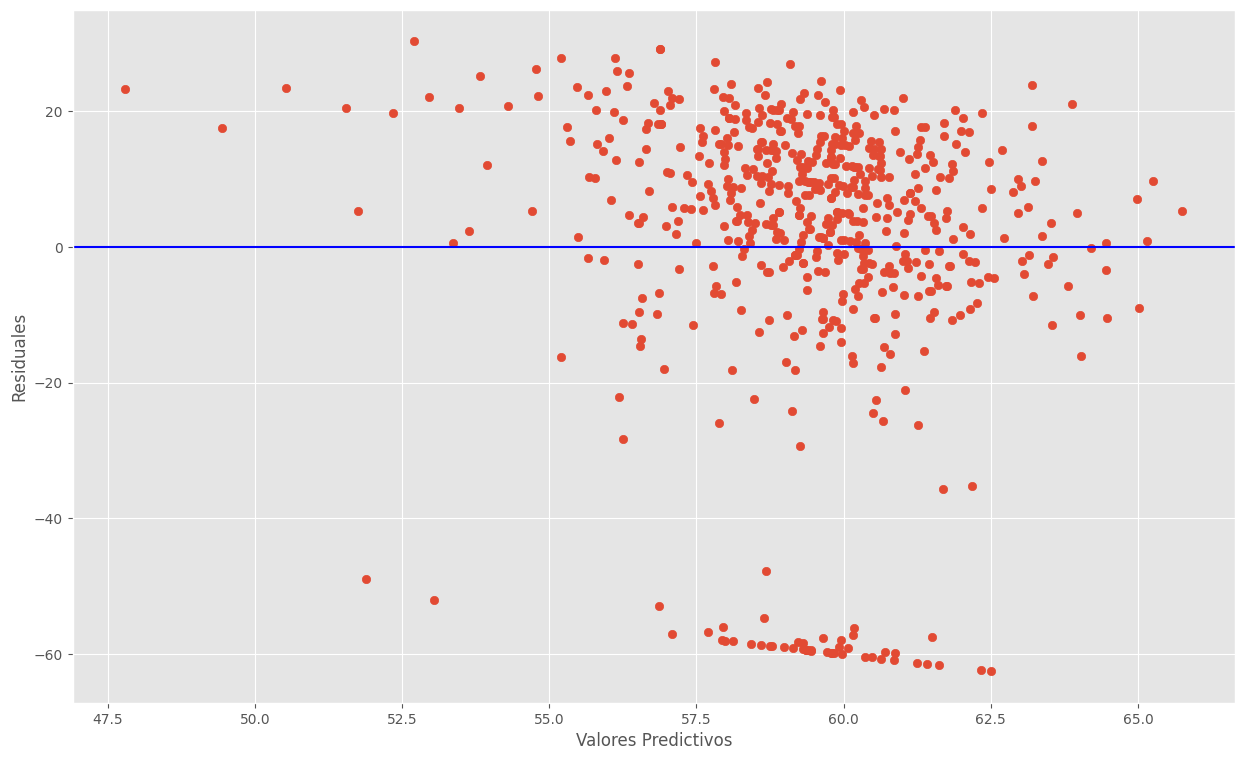

In [1245]:
resid_modelo2=target_test-y_pred_modelo2
plt.scatter(y_pred_modelo2,resid_modelo2)
plt.axhline(0,color='blue')
plt.xlabel('Valores Predictivos')
plt.ylabel('Residuales')

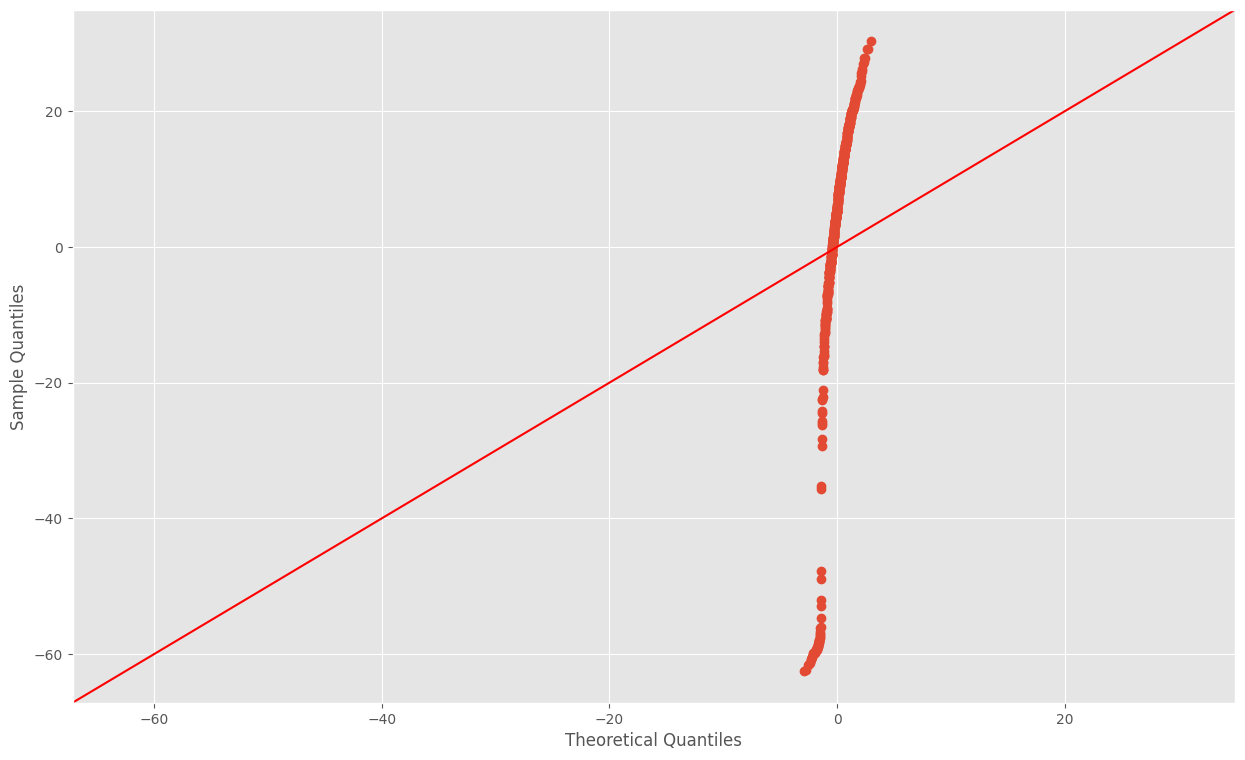

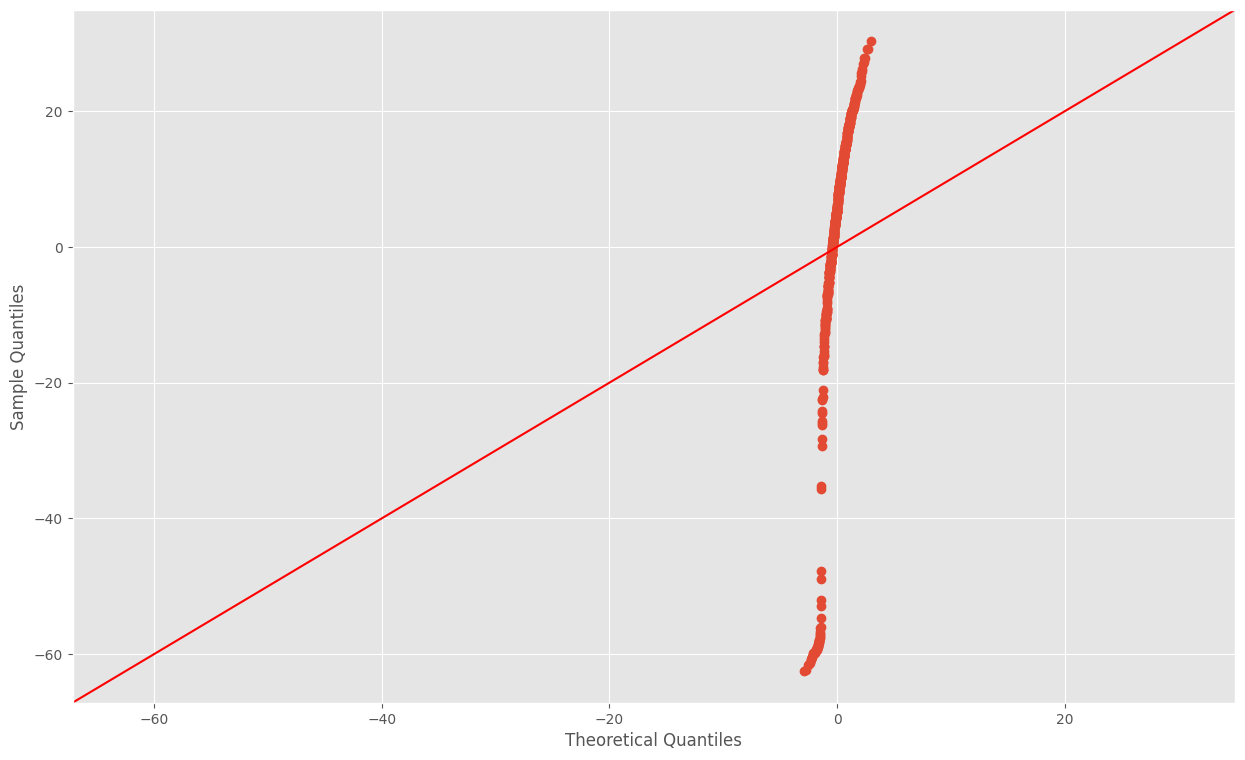

In [1246]:
sm.qqplot(resid_modelo2,line='45')

In [1247]:
k,p=sm.stats.diagnostic.lilliefors(resid_modelo2)
print("p =",p)

p = 0.0009999999999998899


In [1248]:
x_pred_modelo2 = modelo2.predict(X_train_stw)
mse_modelo2_train=metrics.mean_squared_error(target_train, x_pred_modelo2) 

print("MES_train: ",round(mse_modelo2_train,4))
print('MSE_test: ', round(mse_modelo2,4))

MES_train:  464.3058
MSE_test:  431.9124


Modelo 3

In [1249]:
alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))


cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data_train, target_train,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)
train_error = -cv_results["train_score"]
print(f"Error medio cuadrado de la regresión con datos de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

test_error = -cv_results["test_score"]
print(f"Error medio cuadrado de la regresion con los datos de prueba:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")
mse_alphas = [est[-1].cv_values_.mean(axis=0)
            for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas


Error medio cuadrado de la regresión con datos de entrenamiento:
436.383 ± 4.113
Error medio cuadrado de la regresion con los datos de prueba:
438.722 ± 33.258


,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,472.439804,472.439725,472.439623,472.439494,472.439330,472.439120,472.438853,472.438513,472.438079,472.437527,472.436823,472.435926,472.434783,472.433327,472.431472,472.429109,472.426100,472.422267,472.417386,472.411172
1,477.234341,477.234257,477.234150,477.234014,477.233840,477.233618,477.233336,477.232977,477.232519,477.231935,477.231191,477.230243,477.229036,477.227497,477.225538,477.223041,477.219862,477.215812,477.210655,477.204090
2,474.952974,474.952891,474.952785,474.952651,474.952479,474.952261,474.951982,474.951627,474.951175,474.950599,474.949866,474.948931,474.947739,474.946222,474.944288,474.941825,474.938689,474.934694,474.929607,474.923132
3,476.649974,476.649890,476.649782,476.649646,476.649472,476.649250,476.648967,476.648607,476.648148,476.647563,476.646818,476.645868,476.644658,476.643117,476.641153,476.638651,476.635464,476.631405,476.626236,476.619654
4,469.114508,469.114418,469.114304,469.114158,469.113973,469.113737,469.113436,469.113052,469.112563,469.111940,469.111147,469.110136,469.108848,469.107207,469.105116,469.102453,469.099060,469.094740,469.089238,469.082233


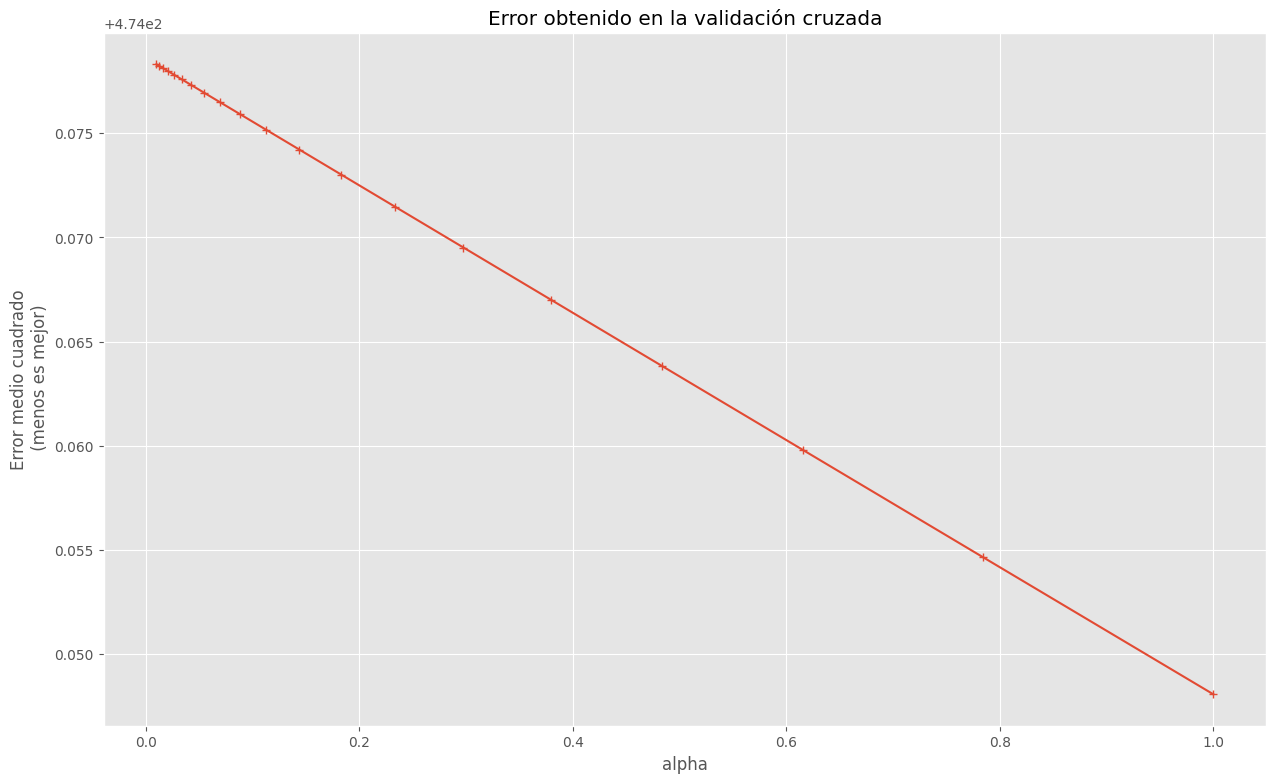

In [1250]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Error medio cuadrado\n (menos es mejor)")
plt.xlabel("alpha")
_ = plt.title("Error obtenido en la validación cruzada")

In [1251]:
mejores_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
mejores_alphas

[1.0, 1.0, 1.0, 1.0, 1.0]

In [1252]:
print(f"El mejor alfa es:\n"
      f"{np.mean(mejores_alphas):.2f} ± {np.std(mejores_alphas):.2f}")

El mejor alfa es:
1.00 ± 0.00


In [1253]:
alfa_modelo3 = np.mean(mejores_alphas)
modelo3 = Ridge(alpha=alfa_modelo3)
modelo3.fit(data_train, target_train)

# Predict the target values on the testing set
y_pred_modelo3 = modelo3.predict(data_test)

In [1254]:
# Regression metrics
explained_variance_modelo3=metrics.explained_variance_score(target_test, y_pred_modelo3)
mean_absolute_error_modelo3=metrics.mean_absolute_error(target_test, y_pred_modelo3) 
mse_modelo3=metrics.mean_squared_error(target_test, y_pred_modelo3) 
mean_squared_log_error_modelo3=metrics.mean_squared_log_error(target_test, y_pred_modelo3)
median_absolute_error_modelo3=metrics.median_absolute_error(target_test, y_pred_modelo3)
r2_modelo3=metrics.r2_score(target_test, y_pred_modelo3)
k = modelo3.coef_.size
n = data_train.shape[0]
aic_modelo3 = calculate_aic(n,mse_modelo3,k)
bic_modelo3 = calculate_bic(n,mse_modelo3,k)

print('explained_variance: ', round(explained_variance_modelo3,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo3,4))
print('r2: ', round(r2_modelo3,4))
print('MAE: ', round(mean_absolute_error_modelo3,4))
print('MSE: ', round(mse_modelo3,4))
print('RMSE: ', round(np.sqrt(mse_modelo3),4))
print('AIC: ',round(aic_modelo3,4))
print('BIC: ',round(bic_modelo3,4))

explained_variance:  -0.0088
mean_squared_log_error:  1.1449
r2:  -0.013
MAE:  14.5088
MSE:  428.6624
RMSE:  20.7042
AIC:  8594.5734
BIC:  8977.0884


#### Modelo 4 (Lasso)

In [1255]:
lasso = make_pipeline(StandardScaler(), LassoCV(alphas = np.arange(0,1,0.02), cv=cv, n_jobs = 2))
cv_results_lasso = cross_validate(lasso, data_train, target_train,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)
train_error = -cv_results_lasso["train_score"]
print(f"Error medio cuadrado de la regresión con datos de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

test_error_lasso = -cv_results_lasso["test_score"]
print(f"Error medio cuadrado de la regresion con los datos de prueba:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")
alphas = []
for est in cv_results_lasso["estimator"]:
    alphas.append(est[1].alpha_)
print
print(alphas)
-cv_results_lasso["test_score"]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247832.78997220108, tolerance: 54.37591028368791
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/L

Error medio cuadrado de la regresión con datos de entrenamiento:
450.989 ± 5.059
Error medio cuadrado de la regresion con los datos de prueba:
438.722 ± 33.258
[0.86, 0.98, 0.6, 0.6, 0.8]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240951.9832557477, tolerance: 52.570792819148956
  model = cd_fast.enet_coordinate_descent_gram(
/L

array([428.51876506, 411.61565292, 408.49145483, 435.32578873,
       479.27912958])

In [1256]:
modelo4 = Lasso(alpha=0.04)
modelo4.fit(data_train, target_train)

# Predict the target values on the testing set
y_pred_modelo4 = modelo4.predict(data_test)

In [1257]:
# Regression metrics
explained_variance_modelo4=metrics.explained_variance_score(target_test, y_pred_modelo4)
mean_absolute_error_modelo4=metrics.mean_absolute_error(target_test, y_pred_modelo4) 
mse_modelo4=metrics.mean_squared_error(target_test, y_pred_modelo4) 
mean_squared_log_error_modelo4=metrics.mean_squared_log_error(target_test, y_pred_modelo4)
median_absolute_error_modelo4=metrics.median_absolute_error(target_test, y_pred_modelo4)
r2_modelo4=metrics.r2_score(target_test, y_pred_modelo4)
k = modelo4.coef_.size
n = data_train.shape[0]
aic_modelo4 = calculate_aic(n,mse_modelo4,k)
bic_modelo4 = calculate_bic(n,mse_modelo4,k)

print('explained_variance: ', round(explained_variance_modelo4,4))   
print('mean_squared_log_error: ', round(mean_squared_log_error_modelo4,4))
print('r2: ', round(r2_modelo4,4))
print('MAE: ', round(mean_absolute_error_modelo4,4))
print('MSE: ', round(mse_modelo4,4))
print('RMSE: ', round(np.sqrt(mse_modelo4),4))
print('AIC: ',round(aic_modelo4,4))
print('BIC: ',round(bic_modelo4,4))

explained_variance:  -0.0012
mean_squared_log_error:  1.1456
r2:  -0.0049
MAE:  14.445
MSE:  425.2304
RMSE:  20.6211
AIC:  8583.3679
BIC:  8965.883


VIF

In [1258]:
# # Añadir una constante para el término de intercepción
# X_train_const_VIF = sm.add_constant(data_train[numerical_cols])

# # Modelo de regresión lineal
# model_VIF = sm.OLS(target_train, X_train_const_VIF).fit()

# # Resumen del modelo
# print(model_VIF.summary())

# # Hacer predicciones
# predictions = model_VIF.predict(X_train_const_VIF)

# # Calculate VIF for each feature
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(data_train[numerical_cols].values, i) for i in range(data_train[numerical_cols].shape[1])]
# vif["features"] = data_train[numerical_cols].columns

# print(vif)

# # Calculate R-squared
# r_squared = model_VIF.rsquared
# print('R-squared:', r_squared)

# # Calculate Adjusted R-squared
# adjusted_r_squared = model_VIF.rsquared_adj
# print('Adjusted R-squared:', adjusted_r_squared)
# # Check for overfitting
# predictions_val = model_VIF.predict(sm.add_constant(data_test[numerical_cols]))
# mse_train = mean_squared_error(target_train, predictions)
# mse_val = mean_squared_error(target_test, predictions_val)

# print('Training MSE:', mse_train)
# print('Validation MSE:', mse_val)

In [1259]:
# X_test_const = sm.add_constant(data_test)

# # Calcular las predicciones del modelo en el conjunto de prueba
# y_pred_test = model.predict(X_test_const)

# # Calcular el MSE en el conjunto de prueba
# mse_test = mean_squared_error(target_test, y_pred_test)
# print("MSE (test):", mse_test)

# # Calcular el MAE en el conjunto de prueba
# mae_test = mean_absolute_error(target_test, y_pred_test)
# print("MAE (test):", mae_test)

# # Calcular el RMSE en el conjunto de prueba
# rmse_test = np.sqrt(mse_test)
# print("RMSE (test):", rmse_test)

# # Crear un gráfico de dispersión de los valores reales vs las predicciones
# plt.scatter(target_test, y_pred_test)
# plt.xlabel('Valores Reales')
# plt.ylabel('Predicciones')
# plt.title('Valores Reales vs Predicciones')

# # Dibujar una línea diagonal (indicando un modelo perfecto)
# plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], color='red', linestyle='--')

# plt.show()

In [1260]:
# model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Use cross-validation
# scores = cross_val_score(model, data_train, target_train, cv=5, scoring='neg_mean_squared_error')

# # Take the square root and make positive (because cross_val_score returns negative values for MSE)
# rmse_scores = np.sqrt(-scores)

# print("RMSE Scores:", rmse_scores)
# print("RMSE Mean:", rmse_scores.mean())
# print("RMSE Standard Deviation:", rmse_scores.std())

In [1261]:
# from sklearn.feature_selection import RFE

# model = Lasso(alpha=0.1)
# rfe = RFE(model, n_features_to_select=3)
# fit = rfe.fit(data_train, target_train)

# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)

In [1262]:
# # Define the model
# model = Lasso(alpha=0.1)

# # Fit the model
# model.fit(data_train, target_train)

# # Make predictions
# y_pred_test = model.predict(data_test)

# # Calculate MSE and RMSE
# mse_test = mean_squared_error(target_test, y_pred_test)
# print("MSE (test):", mse_test)
# mae_test = mean_absolute_error(target_test, y_pred_test)
# print("MAE (test):", mae_test)
# rmse_test = np.sqrt(mse_test)
# print("RMSE (test):", rmse_test)

# # Plot the predictions
# plt.scatter(target_test, y_pred_test)
# plt.xlabel('Valores Reales')
# plt.ylabel('Predicciones')
# plt.title('Valores Reales vs Predicciones')

# # Dibujar una línea diagonal (indicando un modelo perfecto)
# plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], color='red', linestyle='--')

In [1263]:
# # Añadir una constante para el término de intercepción
# X_train_const_VIF = sm.add_constant(data_train[numerical_cols])

# # Modelo de regresión lineal
# model_VIF = sm.OLS(target_train, X_train_const_VIF).fit()

# # Resumen del modelo
# print(model_VIF.summary())

# # Análisis de multicolinealidad (VIF)
# vif_data = pd.DataFrame()
# vif_data["Feature"] = data_train[numerical_cols].columns
# vif_data["VIF"] = [variance_inflation_factor(data_train[numerical_cols].values, i) for i in range(len(data_train[numerical_cols].columns))]
# print("\nAnálisis de multicolinealidad (VIF):")
# print(vif_data)

# # Matriz de correlación
# correlation_matrix = data_train[numerical_cols].corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
# plt.title("Matriz de correlación")
# plt.show()

# # Análisis de residuos
# residuals = target_train - model_VIF.predict(X_train_const_VIF)
# plt.scatter(model_VIF.predict(X_train_const_VIF), residuals)
# plt.axhline(y=0, color='red', linestyle='--')
# plt.xlabel('Predicted Popularity')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

# # Evaluar el modelo en los datos de prueba
# X_test_const_VIF = sm.add_constant(data_test[numerical_cols])
# test_predictions = model_VIF.predict(X_test_const_VIF)
# test_residuals = target_test - test_predictions
# test_r_squared = r2_score(target_test, test_predictions)
# print("\nR^2 en los datos de prueba:", test_r_squared)
